# IDG Split Inspector (MPI3D & Shapes3D)

Este notebook carga tus archivos `.npz` del benchmark (train/test) y **verifica qué valores y qué combinaciones de factores** aparecen en cada split.

- Para cada `dataset` y `split`:
  - Cobertura por factor (valores presentes / ausentes en train y test).
  - Cobertura de **combinaciones completas** (joint combinations) usando un encoding en base mixta.
  - (Opcional) Tablas/heatmaps simples para pares de factores típicos.

> Diseñado para correr directamente sobre los `.npz` que ya descargaste (como `mpi3d_composition_train_labels.npz`, etc.).


In [1]:
# ============================================================
# Cell 1: Imports + Config
# ============================================================
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple, Optional, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Ajusta esto a tu estructura ----
# Si estás en /workspace1/asoto/araymond/, normalmente ../datasets funciona desde scripts/nb en ese repo.
DATA_ROOT = Path("../datasets")  # carpeta que contiene subcarpetas mpi3d/ y shapes3d/
DATASETS = ["mpi3d", "shapes3d"]
SPLITS = ["composition"]  # se analizarán los que existan
MODES = ["train", "test"]

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

print("DATA_ROOT =", DATA_ROOT.resolve())


DATA_ROOT = /workspace1/asoto/araymond/datasets


In [2]:
# ============================================================
# Cell 2: Helpers (load npz + factor names)
# ============================================================
def _load_npz_array(npz_path: Path, prefer_keys: Sequence[str] = ("labels", "y", "arr_0")) -> np.ndarray:
    npz_path = Path(npz_path)
    if not npz_path.exists():
        raise FileNotFoundError(npz_path)
    with np.load(npz_path, allow_pickle=False) as data:
        for k in prefer_keys:
            if k in data.files:
                return data[k]
        return data[data.files[0]]

def _resolve_file(root: Path, dataset: str, split: str, mode: str, kind: str) -> Path:
    # nombres tipo mpi3d_composition_train_labels.npz
    filename = f"{dataset}_{split}_{mode}_{kind}.npz"
    p1 = root / filename
    if p1.exists():
        return p1
    p2 = root / dataset / filename
    if p2.exists():
        return p2
    raise FileNotFoundError(f"No encontré {filename} en {root} ni en {root/dataset}")

def factor_names_for(dataset: str, n_factors: int) -> List[str]:
    if dataset == "shapes3d":
        base6 = ["floor_hue", "wall_hue", "object_hue", "scale", "shape", "orientation"]
        return base6 if n_factors == 6 else [f"factor_{i}" for i in range(n_factors)]
    if dataset == "mpi3d":
        base7 = ["object_color","object_shape","object_size","camera_height","background_color","robot_arm_horizontal","robot_arm_vertical"]
        return base7 if n_factors == 7 else [f"factor_{i}" for i in range(n_factors)]
    # fallback genérico
    return [f"factor_{i}" for i in range(n_factors)]

def discover_available_splits(root: Path, dataset: str) -> List[str]:
    found = set()
    for split in SPLITS:
        ok = True
        for mode in MODES:
            try:
                _resolve_file(root, dataset, split, mode, "labels")
            except FileNotFoundError:
                ok = False
                break
        if ok:
            found.add(split)
    return sorted(found)

for ds in DATASETS:
    avail = discover_available_splits(DATA_ROOT, ds)
    print(f"{ds}: available splits -> {avail if avail else '(none found)'}")


mpi3d: available splits -> ['composition']
shapes3d: available splits -> ['composition']


In [3]:
# ============================================================
# Cell 3: Encoding utilities for full combination coverage
# ============================================================
def infer_factor_sizes(labels_a: np.ndarray, labels_b: np.ndarray) -> List[int]:
    """Infer sizes as max+1 per factor using union of both arrays."""
    if labels_a.ndim == 1:
        labels_a = labels_a[:, None]
    if labels_b.ndim == 1:
        labels_b = labels_b[:, None]
    labs = np.concatenate([labels_a, labels_b], axis=0)
    sizes = (labs.max(axis=0) + 1).astype(int).tolist()
    return sizes

def encode_mixed_radix(labels: np.ndarray, sizes: List[int]) -> np.ndarray:
    """Encode each row of labels into a unique integer code given factor sizes."""
    if labels.ndim == 1:
        labels = labels[:, None]
    labels = labels.astype(np.int64, copy=False)
    sizes = np.asarray(sizes, dtype=np.int64)
    # base-mixed encoding: (((a0)*s1 + a1)*s2 + a2)*...
    code = labels[:, 0].copy()
    for j in range(1, labels.shape[1]):
        code = code * sizes[j] + labels[:, j]
    return code

def decode_mixed_radix(code: np.ndarray, sizes: List[int]) -> np.ndarray:
    """Decode codes back into factor rows."""
    sizes = np.asarray(sizes, dtype=np.int64)
    n_f = len(sizes)
    code = np.asarray(code, dtype=np.int64)
    out = np.zeros((code.size, n_f), dtype=np.int64)
    tmp = code.copy()
    for j in range(n_f - 1, -1, -1):
        out[:, j] = tmp % sizes[j]
        tmp //= sizes[j]
    return out

def total_combinations(sizes: List[int]) -> int:
    t = 1
    for s in sizes:
        t *= int(s)
    return int(t)


In [4]:
# ============================================================
# Cell 4: Core analysis (per factor + full joint combos)
# ============================================================
def analyze_dataset_split(root: Path, dataset: str, split: str) -> Dict[str, object]:
    lab_train = _load_npz_array(_resolve_file(root, dataset, split, "train", "labels"))
    lab_test  = _load_npz_array(_resolve_file(root, dataset, split, "test",  "labels"))

    if lab_train.ndim == 1:
        lab_train = lab_train[:, None]
    if lab_test.ndim == 1:
        lab_test = lab_test[:, None]

    n_factors = lab_train.shape[1]
    names = factor_names_for(dataset, n_factors)
    sizes = infer_factor_sizes(lab_train, lab_test)
    T = total_combinations(sizes)

    # --- Per-factor coverage ---
    per_factor_rows = []
    for j, name in enumerate(names):
        vals_tr = np.unique(lab_train[:, j])
        vals_te = np.unique(lab_test[:, j])
        all_vals = np.unique(np.concatenate([vals_tr, vals_te]))
        missing_tr = np.setdiff1d(all_vals, vals_tr, assume_unique=False)
        missing_te = np.setdiff1d(all_vals, vals_te, assume_unique=False)
        per_factor_rows.append({
            "factor": name,
            "size_union": int(all_vals.size),
            "size_train": int(vals_tr.size),
            "size_test": int(vals_te.size),
            "missing_in_train": missing_tr[:50].tolist(),  # cap for display
            "missing_in_test": missing_te[:50].tolist(),
        })
    df_factor = pd.DataFrame(per_factor_rows)

    # --- Full joint coverage via encoding ---
    codes_tr = encode_mixed_radix(lab_train, sizes)
    codes_te = encode_mixed_radix(lab_test, sizes)

    uniq_tr = np.unique(codes_tr)
    uniq_te = np.unique(codes_te)
    uniq_union = np.union1d(uniq_tr, uniq_te)

    only_train = np.setdiff1d(uniq_tr, uniq_te, assume_unique=False)
    only_test  = np.setdiff1d(uniq_te, uniq_tr, assume_unique=False)

    # sample a few missing combos in train that appear in test, and vice versa
    sample_k = 20
    sample_only_test = only_test[:sample_k]
    sample_only_train = only_train[:sample_k]

    df_only_test = pd.DataFrame(decode_mixed_radix(sample_only_test, sizes), columns=names) if sample_only_test.size else pd.DataFrame(columns=names)
    df_only_train = pd.DataFrame(decode_mixed_radix(sample_only_train, sizes), columns=names) if sample_only_train.size else pd.DataFrame(columns=names)

    summary = {
        "dataset": dataset,
        "split": split,
        "n_train": int(lab_train.shape[0]),
        "n_test": int(lab_test.shape[0]),
        "n_factors": int(n_factors),
        "factor_names": names,
        "factor_sizes_union": sizes,
        "total_theoretical_combos": int(T),
        "unique_train_combos": int(uniq_tr.size),
        "unique_test_combos": int(uniq_te.size),
        "unique_union_combos": int(uniq_union.size),
        "coverage_train": float(uniq_tr.size / T),
        "coverage_test": float(uniq_te.size / T),
        "coverage_union": float(uniq_union.size / T),
        "only_train_combos": int(only_train.size),
        "only_test_combos": int(only_test.size),
    }

    return {
        "summary": summary,
        "df_factor": df_factor,
        "df_only_test": df_only_test,
        "df_only_train": df_only_train,
        "labels_train": lab_train,
        "labels_test": lab_test,
    }

def pretty_print_analysis(res: Dict[str, object]):
    s = res["summary"]
    print(f"\n=== {s['dataset']} | split={s['split']} ===")
    print(f"N train={s['n_train']:,} | N test={s['n_test']:,} | factors={s['n_factors']}")
    print("factor_sizes_union =", s["factor_sizes_union"], "=> total combos =", f"{s['total_theoretical_combos']:,}")
    print(f"unique combos: train={s['unique_train_combos']:,} ({100*s['coverage_train']:.2f}%) | test={s['unique_test_combos']:,} ({100*s['coverage_test']:.2f}%) | union={s['unique_union_combos']:,} ({100*s['coverage_union']:.2f}%)")
    print(f"combos only in train: {s['only_train_combos']:,} | only in test: {s['only_test_combos']:,}")

    display(res["df_factor"])

    if len(res["df_only_test"]) > 0:
        print("\nEjemplos de combinaciones presentes SOLO en test (OOD wrt train):")
        display(res["df_only_test"].head(20))
    else:
        print("\nNo hay combinaciones exclusivas de test (train cubre todo lo que aparece en test).")

    if len(res["df_only_train"]) > 0:
        print("\nEjemplos de combinaciones presentes SOLO en train:")
        display(res["df_only_train"].head(20))
    else:
        print("\nNo hay combinaciones exclusivas de train (test cubre todo lo que aparece en train).")


In [5]:
# ============================================================
# Cell 5: Run analysis for MPI3D + Shapes3D (splits that exist)
# ============================================================
all_summaries = []

for ds in DATASETS:
    avail_splits = discover_available_splits(DATA_ROOT, ds)
    if not avail_splits:
        continue
    for sp in avail_splits:
        res = analyze_dataset_split(DATA_ROOT, ds, sp)
        pretty_print_analysis(res)
        all_summaries.append(res["summary"])

df_summary = pd.DataFrame(all_summaries)
print("\n--- Summary (all datasets/splits found) ---")
display(df_summary[["dataset","split","n_train","n_test","n_factors","total_theoretical_combos","unique_train_combos","unique_test_combos","only_test_combos","coverage_train","coverage_test"]]
        .sort_values(["dataset","split"]))



=== mpi3d | split=composition ===
N train=287,712 | N test=749,088 | factors=7
factor_sizes_union = [6, 6, 2, 3, 3, 40, 40] => total combos = 1,036,800
unique combos: train=287,712 (27.75%) | test=749,088 (72.25%) | union=1,036,800 (100.00%)
combos only in train: 287,712 | only in test: 749,088


,factor,size_union,size_train,size_test,missing_in_train,missing_in_test
0,object_color,6,6,6,[],[]
1,object_shape,6,6,6,[],[]
2,object_size,2,2,2,[],[]
3,camera_height,3,3,3,[],[]
4,background_color,3,3,3,[],[]
5,robot_arm_horizontal,40,40,34,[],"[0, 1, 2, 3, 4, 5]"
6,robot_arm_vertical,40,40,34,[],"[0, 1, 2, 3, 4, 5]"



Ejemplos de combinaciones presentes SOLO en test (OOD wrt train):


,object_color,object_shape,object_size,camera_height,background_color,robot_arm_horizontal,robot_arm_vertical
0,0,0,0,0,0,6,6
1,0,0,0,0,0,6,7
2,0,0,0,0,0,6,8
3,0,0,0,0,0,6,9
4,0,0,0,0,0,6,10
5,0,0,0,0,0,6,11
6,0,0,0,0,0,6,12
7,0,0,0,0,0,6,13
8,0,0,0,0,0,6,14
9,0,0,0,0,0,6,15



Ejemplos de combinaciones presentes SOLO en train:


,object_color,object_shape,object_size,camera_height,background_color,robot_arm_horizontal,robot_arm_vertical
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,2
3,0,0,0,0,0,0,3
4,0,0,0,0,0,0,4
5,0,0,0,0,0,0,5
6,0,0,0,0,0,0,6
7,0,0,0,0,0,0,7
8,0,0,0,0,0,0,8
9,0,0,0,0,0,0,9



=== shapes3d | split=composition ===
N train=153,408 | N test=326,592 | factors=6
factor_sizes_union = [10, 10, 10, 8, 4, 15] => total combos = 480,000
unique combos: train=153,408 (31.96%) | test=326,592 (68.04%) | union=480,000 (100.00%)
combos only in train: 153,408 | only in test: 326,592


,factor,size_union,size_train,size_test,missing_in_train,missing_in_test
0,floor_hue,10,10,9,[],[0]
1,wall_hue,10,10,9,[],[0]
2,object_hue,10,10,9,[],[0]
3,scale,8,8,8,[],[]
4,shape,4,4,4,[],[]
5,orientation,15,15,14,[],[0]



Ejemplos de combinaciones presentes SOLO en test (OOD wrt train):


,floor_hue,wall_hue,object_hue,scale,shape,orientation
0,1,1,1,0,0,1
1,1,1,1,0,0,2
2,1,1,1,0,0,3
3,1,1,1,0,0,4
4,1,1,1,0,0,5
5,1,1,1,0,0,6
6,1,1,1,0,0,7
7,1,1,1,0,0,8
8,1,1,1,0,0,9
9,1,1,1,0,0,10



Ejemplos de combinaciones presentes SOLO en train:


,floor_hue,wall_hue,object_hue,scale,shape,orientation
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,2
3,0,0,0,0,0,3
4,0,0,0,0,0,4
5,0,0,0,0,0,5
6,0,0,0,0,0,6
7,0,0,0,0,0,7
8,0,0,0,0,0,8
9,0,0,0,0,0,9



--- Summary (all datasets/splits found) ---


,dataset,split,n_train,n_test,n_factors,total_theoretical_combos,unique_train_combos,unique_test_combos,only_test_combos,coverage_train,coverage_test
0,mpi3d,composition,287712,749088,7,1036800,287712,749088,749088,0.2775,0.7225
1,shapes3d,composition,153408,326592,6,480000,153408,326592,326592,0.3196,0.6804


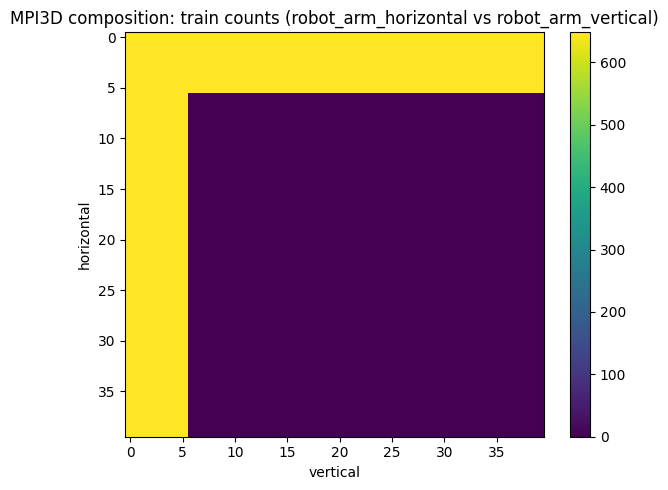

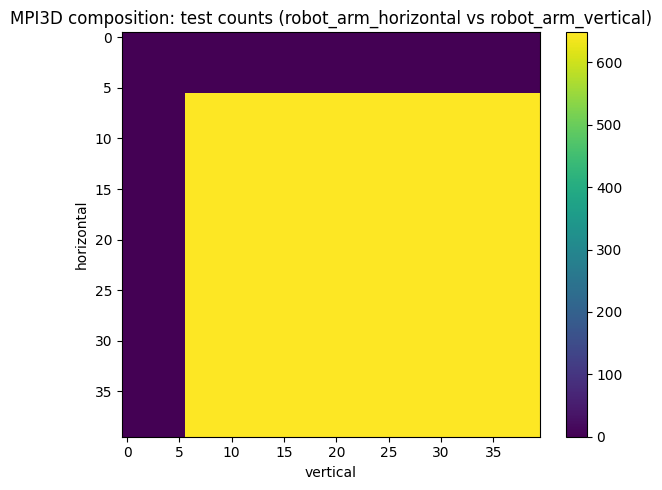

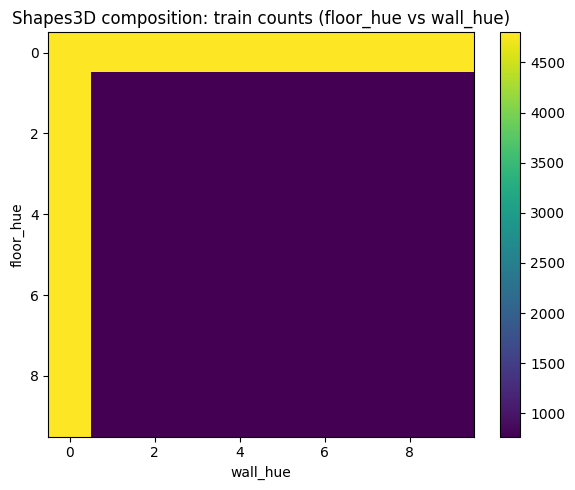

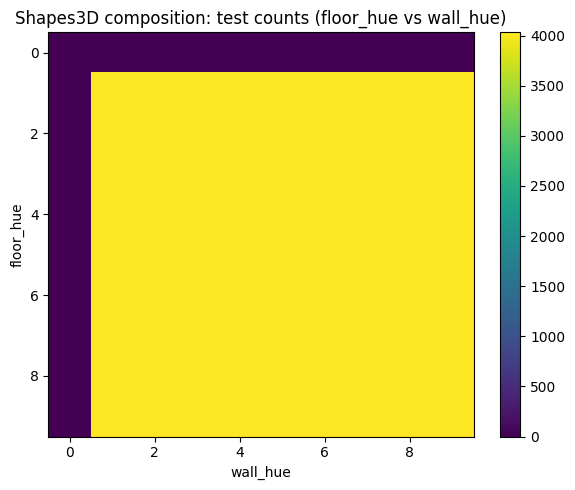

In [6]:
# ============================================================
# Cell 6 (optional): Pairwise coverage heatmaps for 'composition'
#   - MPI3D: robot_arm_horizontal vs robot_arm_vertical
#   - Shapes3D: floor_hue vs wall_hue (and object_hue) as example
# ============================================================
def pair_count_matrix(labels: np.ndarray, i: int, j: int, si: int, sj: int) -> np.ndarray:
    """Counts occurrences for pair (i,j) into a [si, sj] matrix."""
    mat = np.zeros((si, sj), dtype=np.int64)
    a = labels[:, i].astype(np.int64)
    b = labels[:, j].astype(np.int64)
    # vectorized increment
    np.add.at(mat, (a, b), 1)
    return mat

def show_pair_heatmap(mat: np.ndarray, title: str, xlabel: str, ylabel: str):
    plt.figure(figsize=(6,5))
    plt.imshow(mat, aspect="auto")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# MPI3D composition
if "mpi3d" in DATASETS and "composition" in discover_available_splits(DATA_ROOT, "mpi3d"):
    res = analyze_dataset_split(DATA_ROOT, "mpi3d", "composition")
    names = res["summary"]["factor_names"]
    sizes = res["summary"]["factor_sizes_union"]
    lt = res["labels_train"]; le = res["labels_test"]

    i = names.index("robot_arm_horizontal")
    j = names.index("robot_arm_vertical")
    mat_tr = pair_count_matrix(lt, i, j, sizes[i], sizes[j])
    mat_te = pair_count_matrix(le, i, j, sizes[i], sizes[j])

    show_pair_heatmap(mat_tr, "MPI3D composition: train counts (robot_arm_horizontal vs robot_arm_vertical)", "vertical", "horizontal")
    show_pair_heatmap(mat_te, "MPI3D composition: test counts (robot_arm_horizontal vs robot_arm_vertical)", "vertical", "horizontal")

# Shapes3D composition
if "shapes3d" in DATASETS and "composition" in discover_available_splits(DATA_ROOT, "shapes3d"):
    res = analyze_dataset_split(DATA_ROOT, "shapes3d", "composition")
    names = res["summary"]["factor_names"]
    sizes = res["summary"]["factor_sizes_union"]
    lt = res["labels_train"]; le = res["labels_test"]

    i = names.index("floor_hue")
    j = names.index("wall_hue")
    mat_tr = pair_count_matrix(lt, i, j, sizes[i], sizes[j])
    mat_te = pair_count_matrix(le, i, j, sizes[i], sizes[j])

    show_pair_heatmap(mat_tr, "Shapes3D composition: train counts (floor_hue vs wall_hue)", "wall_hue", "floor_hue")
    show_pair_heatmap(mat_te, "Shapes3D composition: test counts (floor_hue vs wall_hue)", "wall_hue", "floor_hue")
